## Brief Code to Quickly Compare Several Baseline Predictive Models

### Introduction

About nine months ago I took [Andrew Ng's awesome Coursera Machine Learning Course](https://www.coursera.org/learn/machine-learning), which I highly recommend. One of the many tips from that course which have significantly improved my process is to take a more agile approach to building predictive models:
  - Implement something quick-and-dirty.
  - Run error analyses and diagnostics to see where your errors come from
  - Fix the errors.

While this wasn't Andrew Ng's suggestion for all scenarios or projects, this approach struck a chord with me. This blog post is about my approach to the first step above: implementing a quick and dirty baseline model. Or more specifically, on how to quickly compare several baseline models. I'll also discuss what sorts of information I'm looking for in this baseline comparison, and how this information can guide further model development.

In a future post, I'll focus on the second step above: run error analyses and diagnostics. 

### Loading a Dataset to Classify: the Digits Dataset

In [1]:
import math
import random
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os

/home/max/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


The MNIST digits datset is a famous dataset of handwritten digit images. You can read more about it at [wikipedia](https://en.wikipedia.org/wiki/MNIST_database) or [Yann LeCun's page](http://yann.lecun.com/exdb/mnist/)

Conveniently, `scikit-learn` has a built-in utility for loading this (and other) standard datsets.

Conveniently, scikit-learn has a utility for loading sample datasets, including the `digits` dataset.

In [3]:
# load mnist data
mnist = fetch_mldata('MNIST original', data_home='datasets/')

# Convert sklearn 'datasets bunch' object to Pandas
y = pd.Series(mnist.target).astype('int').astype('category')
X = pd.DataFrame(mnist.data)

# Change column-names in X to reflect that they are pixel values
X.columns = ['pixel_'+str(x) for x in range(X.shape[1])]

### Explore MNIST as a Addendum at end - move right into post subject here.

### Exploring the MNIST dataset

Let's do some quick exploration of this dataset.

In [4]:
X.shape

(70000, 784)

Our dataset has 70,000 rows, meaning we have data on 70,000 handwritten digit images. The 784 columns represent pixel values for those 28x28 pixel images (28x28 = 784)

In [6]:
X_values = pd.Series(X.values.ravel())
print(" min: {}, \n max: {}, \n mean: {} \n most common value: {}".format(X_values.min(), 
                                                              X_values.max(), 
                                                              X_values.mean(), 
                                                              X_values.value_counts().idxmax()))

 min: 0, 
 max: 255, 
 mean: 33.385964741253645 
 most common value: 0


Now let's check if our dataset is well-balanced.

In [6]:
y.value_counts(normalize=True)

1    0.112529
7    0.104186
3    0.102014
2    0.099857
9    0.099400
0    0.098614
6    0.098229
8    0.097500
4    0.097486
5    0.090186
dtype: float64

Great. Almost all the digits appear in between 9.7% and 10.4% of our rows. 11.3% of our digits are `1`, which is the most common, and `5` is the least common at 9.0%. Overall a very well-balanced dataset

## Viewing the raw Digits Images

As a last step before attempting to classify our digits, let's take a look at some of the digits data as images. After all, our data columns are pixel-values for images. The matplotlib function `imshow` comes in handy here.

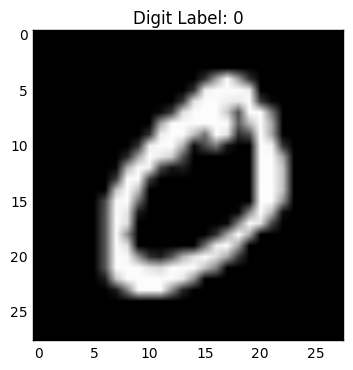

In [7]:
# First row is first image
first_image = X.loc[0,:]
first_label = y[0]

# 784 columns correspond to 28x28 image
plottable_image = np.reshape(first_image.values, (28, 28))

# Plot the image
plt.imshow(plottable_image, cmap='gray')
plt.title('Digit Label: {}'.format(first_label))
plt.show()

And here's a few more...

In [8]:
images_to_plot = 9
random_indices = random.sample(range(70000), images_to_plot)

sample_images = X.loc[random_indices, :]
sample_labels = y.loc[random_indices]

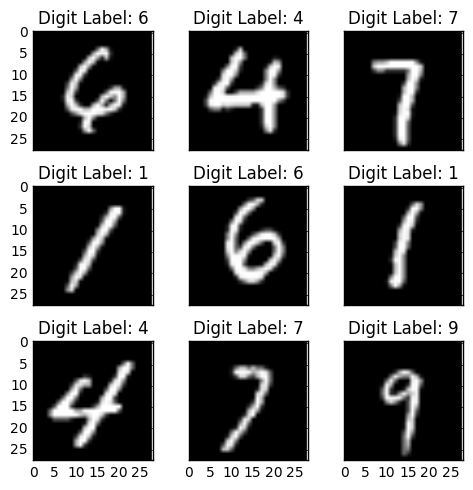

In [9]:
plt.clf()
plt.style.use('seaborn-muted')

fig, axes = plt.subplots(3,3, 
                         figsize=(5,5),
                         sharex=True, sharey=True,
                         subplot_kw=dict(adjustable='box-forced', aspect='equal')) #https://stackoverflow.com/q/44703433/1870832

for i in range(images_to_plot):
    
    # axes (subplot) objects are stored in 2d array, accessed with axes[row,col]
    subplot_row = i//3 
    subplot_col = i%3  
    ax = axes[subplot_row, subplot_col]

    # plot image on subplot
    plottable_image = np.reshape(sample_images.iloc[i,:].values, (28,28))
    ax.imshow(plottable_image, cmap='gray')
    
    ax.set_title('Digit Label: {}'.format(sample_labels.iloc[i]))
    ax.set_xbound([0,28])

plt.tight_layout()
plt.show()

## Classifying Handwritten Digit Images

For all of our models, we'll split our data into `train` and `test` sets. We train or 'learn'(v) our model on `train`, and measure accuracy/error on the `test` set.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .4)

In [11]:
X_train.shape

(42000, 784)

### Baseline Model

First let's see what accuracy we can get from a few 'out of the box' models, without any preprocessing.

In [16]:
from datetime import datetime
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

# initialize classifiers
clf_logreg = LogisticRegression()
clf_xgb = xgb.XGBClassifier()
clf_knn = KNeighborsClassifier()
clf_svm = LinearSVC()

# train each clf on progressively more and more rows, 
# recording accuracy and time required for each
num_rows = [100, 1000, 2000, 5000, 10000, 20000]
clfs = [clf_logreg, clf_xgb, clf_knn, clf_svm]

for rows in num_rows:
    for clf in clfs:

        # Sample X_train data/labels
        sample_indices = random.sample(range(X_train.shape[0]), rows)
        X_train_sample = X_train.iloc[sample_indices,:]
        y_train_sample = y_train.iloc[sample_indices]
        
        # Learn a Model based on Training Data
        time0 = datetime.now()
        clf.fit(X_train_sample, y_train_sample)
        time1 = datetime.now()
    
        # Predict on Test Set and Calculate Accuracy
        preds_test = clf.predict(X_test)
        time2 = datetime.now()
        accuracy = '{:.1%}'.format(accuracy_score(y_test, preds_test))
    
        # Print Resultsrandom.sample(range(1, 100), 3)
        clf_type = clf.__class__.__name__
        fit_time = round((time1-time0).total_seconds()/60, 1)
        pred_time= round((time2-time1).total_seconds()/60, 1)


        print('Results for {} on {} rows'.format(clf_type, rows))
        print('Fit time: {} minutes, / Predict time: {} minutes, / Prediction Accuracy: {}'.format(fit_time,
                                                                                                   pred_time,
                                                                                                   accuracy))        
        print('-----------------------------------------------------------------------------------------------')
    print('--------------------------------------------------------------------------------------------------\n')


Results for LogisticRegression on 100 rows
Fit time: 0.0 minutes, / Predict time: 0.0 minutes, / Prediction Accuracy: 68.0%
-----------------------------------------------------------------------------------------------
Results for XGBClassifier on 100 rows
Fit time: 0.0 minutes, / Predict time: 0.0 minutes, / Prediction Accuracy: 60.4%
-----------------------------------------------------------------------------------------------
Results for KNeighborsClassifier on 100 rows
Fit time: 0.0 minutes, / Predict time: 0.1 minutes, / Prediction Accuracy: 62.0%
-----------------------------------------------------------------------------------------------
Results for LinearSVC on 100 rows
Fit time: 0.0 minutes, / Predict time: 0.0 minutes, / Prediction Accuracy: 71.5%
-----------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------

Results for LogisticRegression o

KeyboardInterrupt: 

## T-SNE Embedding

In [55]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
tsne = TSNE()
tsne

# It is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or 
# TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g. 50) 
# if the number of features is very high.
rows=5000
sample_indices = random.sample(range(X_train.shape[0]), rows)
X_train_sample = X_train.iloc[sample_indices,:]
y_train_sample = y_train.iloc[sample_indices]

# https://www.reddit.com/r/MachineLearning/comments/47kf7w/scikitlearn_tsne_implementation/ (suggests lr=200)
pca_preprocessed_tsne = make_pipeline(PCA(n_components=50), TSNE(n_components=2, learning_rate=200, perplexity=50))
embedded_data = pca_preprocessed_tsne.fit_transform(X_train_sample)

In [56]:
print(embedded_data.shape)
print(embedded_data[:3])
X = embedded_data

(5000, 2)
[[ 2.44066881  2.68993196]
 [-2.05323017  2.04922149]
 [-1.69185259  1.98081708]]


In [37]:
X[0,1]

-1.975785488459002

## Plot TSNE Clusters

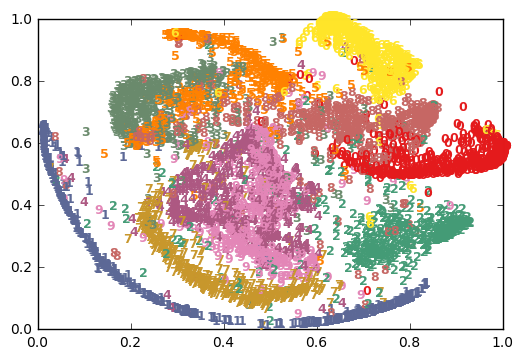

In [58]:
#fig, ax = plt.subplot(1,1)

plt.figure()
ax = plt.subplot(111)
X = embedded_data

x_min, x_max = np.min(X, 0), np.max(X, 0)
X = (X - x_min) / (x_max - x_min)

for i in range(X.shape[0]):
    plt.text(X[i, 0], X[i, 1], str(y_train_sample.iloc[i]),
             color=plt.cm.Set1(y_train_sample.iloc[i] / 10.),
             fontdict={'weight': 'bold', 'size': 9})

plt.show()

In [47]:


def plot_embedding(X, y, title='title'):
    '''params
    ---------
    X - TSNE embedded data (2d)
    y - labels
    '''
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]), #digits.target
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

#    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
#        shown_images = np.array([[1., 1.]])  # just something big
#        for i in range(X.shape[0]): #digits.target (X is just 2d tsne, but should still have same shape[0] (rows))
#            dist = np.sum((X[i] - shown_images) ** 2, 1)
#            if np.min(dist) < 4e-3:
                # don't show points that are too close
#                continue
#            shown_images = np.r_[shown_images, [X[i]]]
#            imagebox = offsetbox.AnnotationBbox(
#                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
#                X[i])
#            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
    plt.show()

In [49]:
y_arr

[0, 0, 0, 0, 0, ..., 9, 9, 9, 9, 9]
Length: 70000
Categories (10, int64): [0, 1, 2, 3, ..., 6, 7, 8, 9]

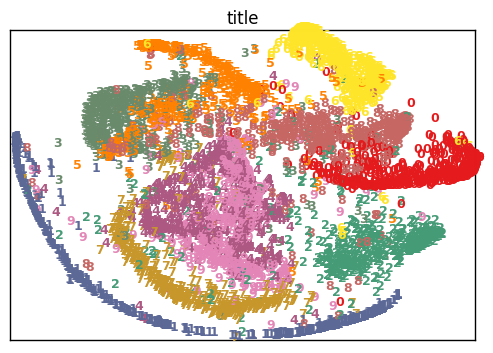

In [59]:
y_arr = y_train_sample.values

plot_embedding(embedded_data, y_arr)

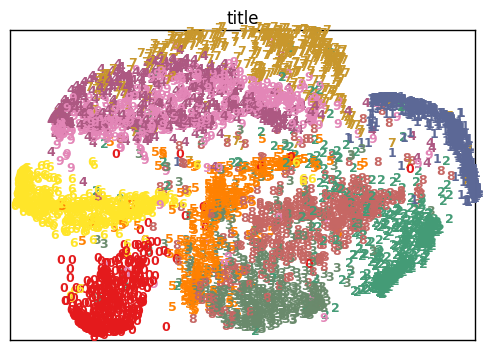

In [70]:
# https://www.reddit.com/r/MachineLearning/comments/47kf7w/scikitlearn_tsne_implementation/ (suggests lr=200)
pca_preprocessed_tsne = make_pipeline(PCA(n_components=50), 
                                      TSNE(n_components=2, 
#                                           init='pca', 
                                           learning_rate=200, 
                                           perplexity=50, 
                                           random_state=42,
                                           method='exact')) #bh default, or 'exact'

embedded_data = pca_preprocessed_tsne.fit_transform(X_train_sample)

plot_embedding(embedded_data, y_arr)


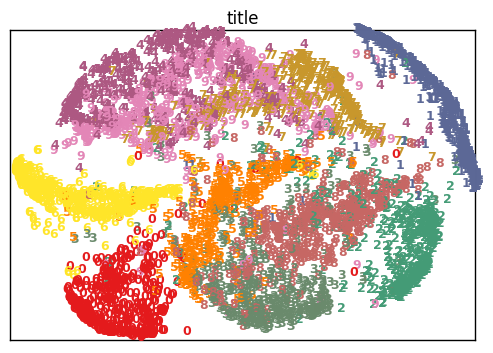

In [72]:
# https://www.reddit.com/r/MachineLearning/comments/47kf7w/scikitlearn_tsne_implementation/ (suggests lr=200)
pca_preprocessed_tsne = make_pipeline(PCA(n_components=30), 
                                      TSNE(n_components=2, 
#                                           init='pca', 
                                           learning_rate=200, 
                                           perplexity=30, 
                                           random_state=42,
                                           method='exact')) #bh default, or 'exact'

embedded_data = pca_preprocessed_tsne.fit_transform(X_train_sample)

plot_embedding(embedded_data, y_arr)
